In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import gaussian_kde  # for version=2

In [18]:
csv_file = r"C:\Users\zheng\Downloads\data_three_groups.csv"  # <-- your CSV path
x_col, y_col, group_col = "X_value", "Y_value", "Group"
x_label, y_label = "X Value", "Y Value"

version = 2                      # 1 = boxplot margins, 2 = density (KDE) margins
confidence_level = 0.95          # CI for the mean regression
figsize = (7, 7)
colors = ['#96CCEA', '#B2A3DD', '#ED949A', '#8BD17C', '#F7C948']  # will cycle



In [19]:
def regression_with_ci(x, y, x_grid, alpha=0.05):
    """Fit y ~ a + b*x; return mean prediction and (1-alpha) CI along x_grid."""
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).reshape(-1, 1)
    lr = LinearRegression().fit(x, y)
    y_hat = lr.predict(x)
    y_grid_hat = lr.predict(x_grid.reshape(-1, 1)).ravel()

    n = len(x)
    dof = n - 2
    if dof <= 0:
        # Not enough points to form CI
        return y_grid_hat, np.full_like(y_grid_hat, np.nan), np.full_like(y_grid_hat, np.nan)

    residuals = (y - y_hat).ravel()
    s_err = np.sqrt(np.sum(residuals**2) / dof)

    xv = x.ravel()
    x_bar = xv.mean()
    Sxx = np.sum((xv - x_bar) ** 2)
    Sxx = Sxx if Sxx > 0 else np.finfo(float).eps

    se_mean = s_err * np.sqrt(1.0/n + (x_grid - x_bar)**2 / Sxx)
    t_crit = stats.t.ppf(1.0 - alpha/2.0, dof)
    ci_lower = y_grid_hat - t_crit * se_mean
    ci_upper = y_grid_hat + t_crit * se_mean
    return y_grid_hat, ci_lower, ci_upper


def draw_joint_plot(df, version=2, output_filename=None):
    # Clean & get groups
    df = df[[x_col, y_col, group_col]].dropna()
    groups = list(df[group_col].unique())

    # --- Figure & axes layout (main + top + right) ---
    fig = plt.figure(figsize=figsize, dpi=150)
    gs = GridSpec(2, 2, width_ratios=[4, 1.2], height_ratios=[1.2, 4], wspace=0.05, hspace=0.05)
    top_ax   = fig.add_subplot(gs[0, 0])
    right_ax = fig.add_subplot(gs[1, 1])
    main_ax  = fig.add_subplot(gs[1, 0])

    # Marginal axes cosmetic
    top_ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    right_ax.tick_params(axis='y', which='both', left=False, labelleft=False)

    # Pre-set limits with padding so points/bands don't touch borders
    x_range = df[x_col].max() - df[x_col].min()
    y_range = df[y_col].max() - df[y_col].min()
    x_range = x_range if x_range != 0 else 1e-6
    y_range = y_range if y_range != 0 else 1e-6
    x_pad = x_range * 0.08
    y_pad = y_range * 0.08
    main_ax.set_xlim(df[x_col].min() - x_pad, df[x_col].max() + x_pad)
    main_ax.set_ylim(df[y_col].min() - y_pad, df[y_col].max() + y_pad)

    # --- Scatter + regressions per group ---
    results = []
    group_data_list = []
    for i, g in enumerate(groups):
        sub = df[df[group_col] == g]
        c = colors[i % len(colors)]
        group_data_list.append((g, sub, c))

        main_ax.scatter(sub[x_col], sub[y_col], s=60, alpha=0.7,
                        facecolors=c, edgecolors='black', linewidths=1, label=str(g))

        if len(sub) > 1:
            X = sub[[x_col]].values
            y = sub[y_col].values
            model = LinearRegression().fit(X, y)
            y_pred = model.predict(X)
            ss_res = np.sum((y - y_pred) ** 2)
            ss_tot = np.sum((y - y.mean()) ** 2)
            r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

            x_min, x_max = float(X.min()), float(X.max())
            if np.isclose(x_min, x_max):
                x_min -= 1e-6; x_max += 1e-6
            x_vals = np.linspace(x_min, x_max, 200)
            y_vals = model.predict(x_vals.reshape(-1, 1))

            if len(sub) > 2:
                _, ci_lo, ci_hi = regression_with_ci(sub[x_col].values, sub[y_col].values,
                                                     x_vals, alpha=1.0 - confidence_level)
                main_ax.fill_between(x_vals, ci_lo, ci_hi, color=c, alpha=0.2)

            main_ax.plot(x_vals, y_vals, color=c, linestyle='--', linewidth=2.5, alpha=0.85)

            results.append({'group': g, 'r2': float(r2), 'n': int(len(sub)), 'color': c})

    # --- Marginal plots: choose ONE branch ---
    if version == 1:
        # Boxplots
        for i, (g, sub, c) in enumerate(group_data_list, start=1):
            bp_x = top_ax.boxplot([sub[x_col].values], positions=[i], vert=False, patch_artist=True,
                                  widths=0.6, showfliers=False,
                                  boxprops=dict(linewidth=2, color=c),
                                  medianprops=dict(linewidth=2, color=c),
                                  whiskerprops=dict(linewidth=1.5, color=c),
                                  capprops=dict(linewidth=1.5, color=c))
            bp_x['boxes'][0].set_facecolor(c); bp_x['boxes'][0].set_alpha(0.7)

            bp_y = right_ax.boxplot([sub[y_col].values], positions=[i], vert=True, patch_artist=True,
                                    widths=0.6, showfliers=False,
                                    boxprops=dict(linewidth=2, color=c),
                                    medianprops=dict(linewidth=2, color=c),
                                    whiskerprops=dict(linewidth=1.5, color=c),
                                    capprops=dict(linewidth=1.5, color=c))
            bp_y['boxes'][0].set_facecolor(c); bp_y['boxes'][0].set_alpha(0.7)

        top_ax.set_ylim(0.5, len(group_data_list) + 0.5)
        right_ax.set_xlim(0.5, len(group_data_list) + 0.5)

    elif version == 2:
        # KDE densities
        x_lo, x_hi = main_ax.get_xlim()
        y_lo, y_hi = main_ax.get_ylim()
        x_plot = np.linspace(x_lo, x_hi, 240)
        y_plot = np.linspace(y_lo, y_hi, 240)
        for g, sub, c in group_data_list:
            xv = sub[x_col].values
            yv = sub[y_col].values
            if len(xv) >= 2 and np.std(xv) > 0:
                kde_x = gaussian_kde(xv)
                top_ax.plot(x_plot, kde_x(x_plot), color=c, linewidth=1.8)
                top_ax.fill_between(x_plot, kde_x(x_plot), alpha=0.30, color=c)
            if len(yv) >= 2 and np.std(yv) > 0:
                kde_y = gaussian_kde(yv)
                right_ax.plot(kde_y(y_plot), y_plot, color=c, linewidth=1.8)
                right_ax.fill_betweenx(y_plot, kde_y(y_plot), alpha=0.30, color=c)

    # Align limits + cosmetics for marginal axes
    top_ax.set_xlim(main_ax.get_xlim())
    right_ax.set_ylim(main_ax.get_ylim())
    for ax in [top_ax, right_ax]:
        for s in ax.spines.values():
            s.set_visible(False)
        ax.set_xticks([]); ax.set_yticks([])

    # Labels, grid, per-group R^2 text
    main_ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
    main_ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
    main_ax.grid(alpha=0.15)

    y_pos = 0.93
    for r in results:
        main_ax.text(0.03, y_pos, f"{r['group']}: $R^2$ = {r['r2']:.3f}",
                     color=r['color'], transform=main_ax.transAxes,
                     fontsize=12, fontweight='bold')
        y_pos -= 0.06

    # Legend
    handles, labels = main_ax.get_legend_handles_labels()
    if handles:
        main_ax.legend(frameon=False, fontsize=10, loc='best')

    # Show / Save
    plt.tight_layout()
    if output_filename:
        os.makedirs(os.path.dirname(output_filename), exist_ok=True)
        plt.savefig(output_filename, dpi=600, bbox_inches='tight', pad_inches=0.1)
        print(f"Saved to: {output_filename}")
    plt.show()




C:\Users\zheng\AppData\Local\Temp\ipykernel_11384\1314251818.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


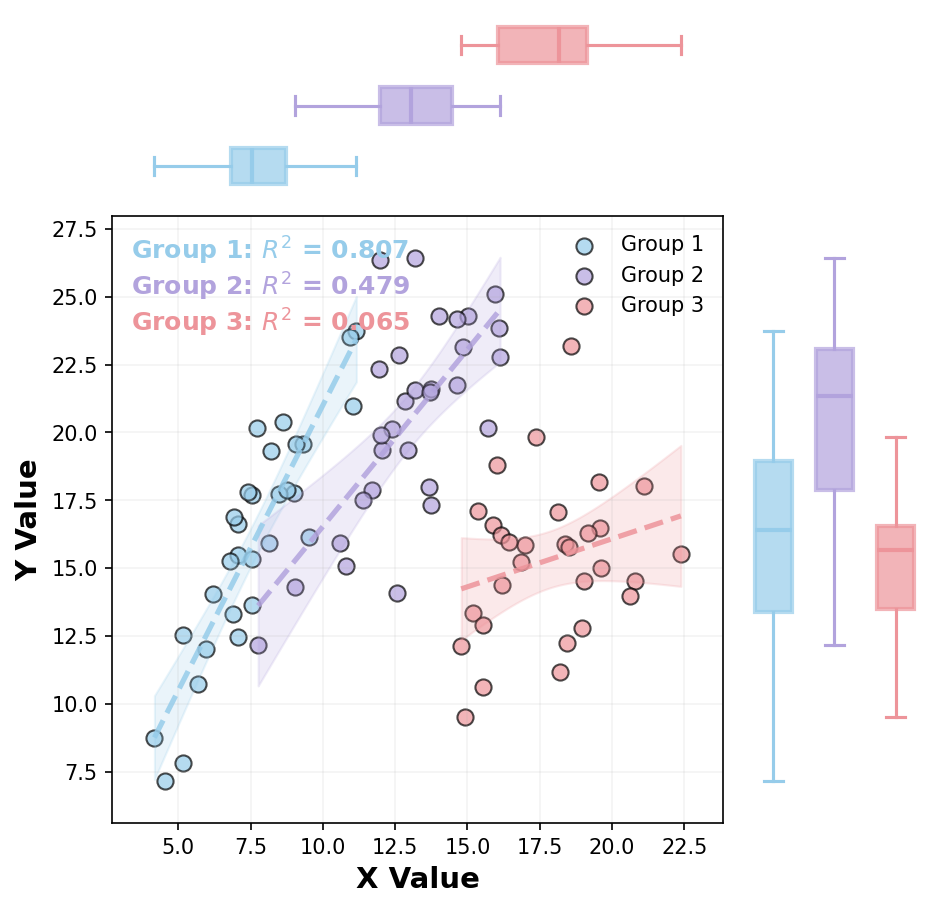

In [20]:
draw_joint_plot(df, version=1, output_filename=None)

C:\Users\zheng\AppData\Local\Temp\ipykernel_11384\1314251818.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


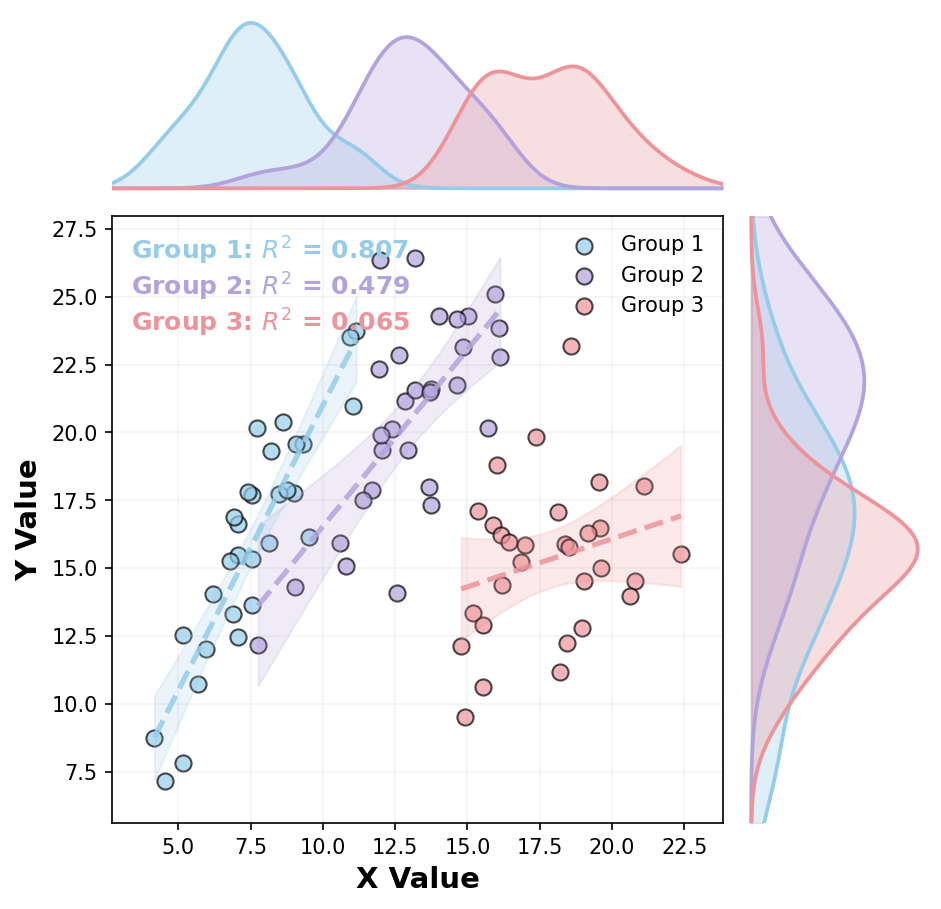

In [21]:
draw_joint_plot(df, version=2, output_filename=None)